In [1]:
!pip install cowsay

  Using cached cowsay-4.0-py2.py3-none-any.whl (24 kB)


In [2]:
import cowsay
cowsay.stegosaurus('Вашему вниманию представляется шляпа')

  ____________________________________
| Вашему вниманию представляется шляпа |
                                            \
                                             \
                                              \
                                               \
                                                                         / `.   .' "
                                                                 .---.  <    > <    >  .---.
                                                                 |    \  \ - ~ ~ - /  /    |
                                             _____          ..-~             ~-..-~
                                            |     |   \~~~\.'                    `./~~~/
                                           ---------   \__/                        \__/
                                          .'  O    \     /               /       \  "
                                         (_____,    `._.'               |         }  \/~~~/
                    

In [3]:
%matplotlib inline
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from IPython.display import Image
from networkx.algorithms.approximation import clique, vertex_cover
from networkx.algorithms.bipartite.covering import min_edge_cover

plt.rcParams["figure.figsize"] = (16, 9)

### Imported modules explained
1) `networkx` is the main power: most of the tasks were done by using implemented `networkx `tools <br>
2) `numpy` and `pandas` were used to preprocess the data:

    1. List of European countries
    2. List of land borders
    3. Happiness ranking for Prufer sequence

3) `matplotlib` was used to display networkx outputs <br>
4) `re` was used to format strings via regular expressions during data preprocessing <br>

In [4]:
# pd.set_option('display.max_rows', 500)

### Preprocessing the 'Graph of Europe' data:
> Copy all European countries and read them into pandas.DataFrame

> Parse the table from "https://en.wikipedia.org/wiki/List_of_countries_and_territories_by_land_borders", using IMPORT_HTML() from googlesheets

> Read 'Land borders' data into pandas.DataFrame and then filter by countries

In [47]:
Europe = nx.Graph()
countries = pd.read_csv('countries.csv')
Europe.add_nodes_from(countries['country'])

In [48]:
doc_id = '1AYODVslftthH3aI8gS0d4wgyLZwwXMpD4bQOSv5M4GI'
url = url = f'https://docs.google.com/spreadsheets/d/{doc_id}/export?format=csv'
df = pd.read_csv(url)
df = df.drop([0], axis=0)
df.head()

,Country or territory\n*(Territories without full sovereignty in italics)* [2],Total length of land borders,Unnamed: 2,No. of distinct land borders,No. of distinct land neighbours,Land border neighbours\nand border length\n\n*(Territories without full sovereignty in italics) [2](#) = No. of distinct \nland boundaries with that country or territory*
1,* Abkhazia*,382,237,2,2,Russia: 241 km (150 mi)\n Georgia: 141 km (88 mi)
2,* Afghanistan*,"5,529","3,436",6,6,People's Republic of China: 76 km (47 mi)\n Ir...
3,* Albania*,720,450,4,4,Greece: 282 km (175 mi)\n* Kosovo*:[4] 112 km ...
4,* Algeria*,"6,47","4,02",7,7,"Libya: 982 km (610 mi)\n Mali: 1,376 km (855 m..."
5,* Andorra*,120,75,2,2,France: 56.6 km (35.2 mi)\n Spain: 63.7 km (39...


Now we have to drop and rename some columns 

In [7]:
df.columns

Index(['Country or territory\n*(Territories without full sovereignty in italics)* [2]',
       'Total length of land borders', 'Unnamed: 2',
       'No. of distinct land borders', 'No. of distinct land neighbours',
       'Land border neighbours\nand border length\n\n*(Territories without full sovereignty in italics) [2](#) = No. of distinct \nland boundaries with that country or territory*'],
      dtype='object')

In [49]:
borders = df.rename(columns={'Country or territory\n*(Territories'
                   ' without full sovereignty in italics)* [2]': 
                   'country',
                   'Land border neighbours\nand border'
                   ' length\n'
                   '\n*(Territories without full sovereignty in italics) '
                   '[2](#) = No. of distinct \nland boundaries with that country or territory*': \
                   'neighbours'
                  }).drop(['Total length of land borders', 'Unnamed: 2'
                           ,'No. of distinct land borders', 'No. of distinct land neighbours']
                        , axis=1)
borders['country'] = borders['country'].str.replace('*', '').str.strip()
borders['country'] = borders['country'].str.replace(r'\[([0-9_]+)\]', '', regex=True) \
    .str.replace(r'\(([0-9_])+\)', '', regex=True)
# Too lazy to reformat France and Netherlands automatically
borders.at[63, 'country'] = 'France'
borders.at[131, 'country'] = 'Netherlands'
borders

/var/folders/6d/jcsgnwtj1857x2zvzznd28jw0000gn/T/ipykernel_755/2807389908.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  borders['country'] = borders['country'].str.replace('*', '').str.strip()


,country,neighbours
1,Abkhazia,Russia: 241 km (150 mi)\n Georgia: 141 km (88 mi)
2,Afghanistan,People's Republic of China: 76 km (47 mi)\n Ir...
3,Albania,Greece: 282 km (175 mi)\n* Kosovo*:[4] 112 km ...
4,Algeria,"Libya: 982 km (610 mi)\n Mali: 1,376 km (855 m..."
5,Andorra,France: 56.6 km (35.2 mi)\n Spain: 63.7 km (39...
...,...,...
201,Vietnam,"Cambodia: 1,228 km (763 mi)\n People's Republi..."
202,Western Sahara,"Algeria: 42 km (26 mi)\n Mauritania: 1,561 km ..."
203,Yemen,"Oman: 288 km (179 mi)\n Saudi Arabia: 1,458 km..."
204,Zambia,"Angola: 1,110 km (690 mi)\n Botswana: 0.15 km ..."


In [9]:
borders[['country']]

,country
1,Abkhazia
2,Afghanistan
3,Albania
4,Algeria
5,Andorra
...,...
201,Vietnam
202,Western Sahara
203,Yemen
204,Zambia


In [50]:
edges_df = countries.merge(borders, how='left')
edges_df['neighbours'] =  edges_df['neighbours'].str.split('\n')
edges_df['neighbours'] = edges_df['neighbours'].fillna("").apply(list)

In [51]:
for index, row in edges_df.iterrows():
    for neighbour in row['neighbours']:
        temp = neighbour.split(':')[0].replace('*', '')
        temp = re.sub("\[([0-9_]+)\]", "", temp)
        temp = re.sub("\(([0-9_])+\)", "", temp)
        temp = temp.strip()
        if temp in list(edges_df['country']):
            Europe.add_edge(row['country'], temp)

The end of preprocessing

#### 1a
#### Draw `G*` with the minimum number of intersecting edges

Using `nx.draw_planar()` to draw *the graph of Europe* with minimum number of intersections 


`Europe` turned out to be planar, so there were no edge intersections<br>

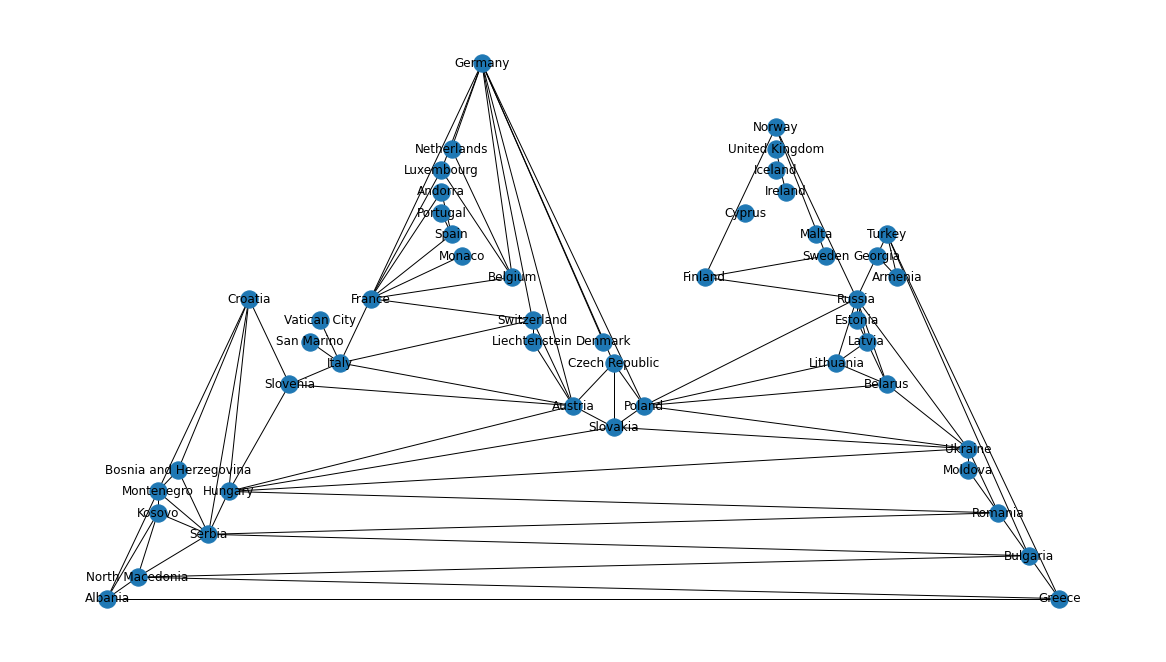

In [52]:
nx.draw_planar(Europe, with_labels=True)

#### 1b

#### Find |V|, |E|, δ (G), Δ(G), rad(G), diam(G), girth(G), center(G), κ(G), λ(G).

In [14]:
G = Europe.subgraph(max(nx.connected_components(Europe)))

In [55]:
print('|V|:', G.number_of_nodes())
print('|E|:', G.number_of_edges())

min_graph_degree = min([x[1] for x in G.degree()])
max_graph_degree = max([x[1] for x in G.degree()])

print('Minimal graph degree:', min_graph_degree)
print('Maximal graph degree:', max_graph_degree)

print('Diameter:', nx.diameter(G))

print('Girth:', min([len(cycle) for cycle in nx.cycle_basis(G)]))

print(f'\nCenter:', nx.center(G))
print('Minimum vertex cut:' \
      , nx.minimum_node_cut(G))
print('Minimum edge cut:' \
      , nx.minimum_edge_cut(G))  

|V|: 44
|E|: 91
Minimal graph degree: 1
Maximal graph degree: 9
Diameter: 8
Girth: 3

Center: ['Austria', 'Belarus', 'Croatia', 'Czech Republic', 'Germany', 'Hungary', 'Lithuania', 'Poland', 'Russia', 'Slovakia', 'Slovenia', 'Switzerland', 'Ukraine']
Minimum vertex cut: {'Germany'}
Minimum edge cut: {('Spain', 'Portugal')}


#### 1c

#### Find the minimum vertex coloring Z : V → N of G.

Using `nx.greedy_color()` to get the minimum vertex coloring, then print the number of colors and display the colored graph

Arguments:
<!--  -->
    1. Graph G
    2. Coloring algorithm (I picked smallest_last, as it gave me the minimum number of colors)
    

Minimum coloring size: 4


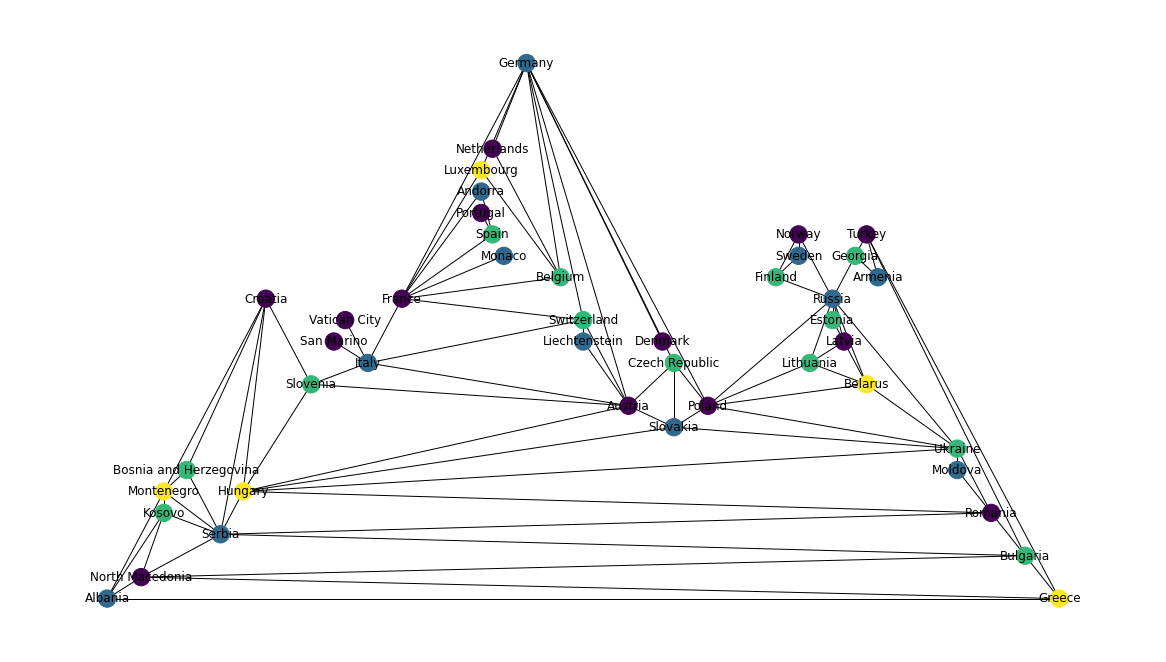

In [56]:
node_colors = nx.greedy_color(G, 'smallest_last')

print('Minimum coloring size:', pd.Series(node_colors.values()).nunique())

nx.draw_planar(G, node_color=[node_colors[node] for node in G.nodes()], with_labels=True)

#### 1d

#### Find the minimum edge coloring X : E → N of G.

'Find edge coloring for G' is equal to vertex coloring for line_graph(G) <br>
Therefore, I constructed a line graph L of G and found minimum vertex coloring for L

Size of edge coloring: 9


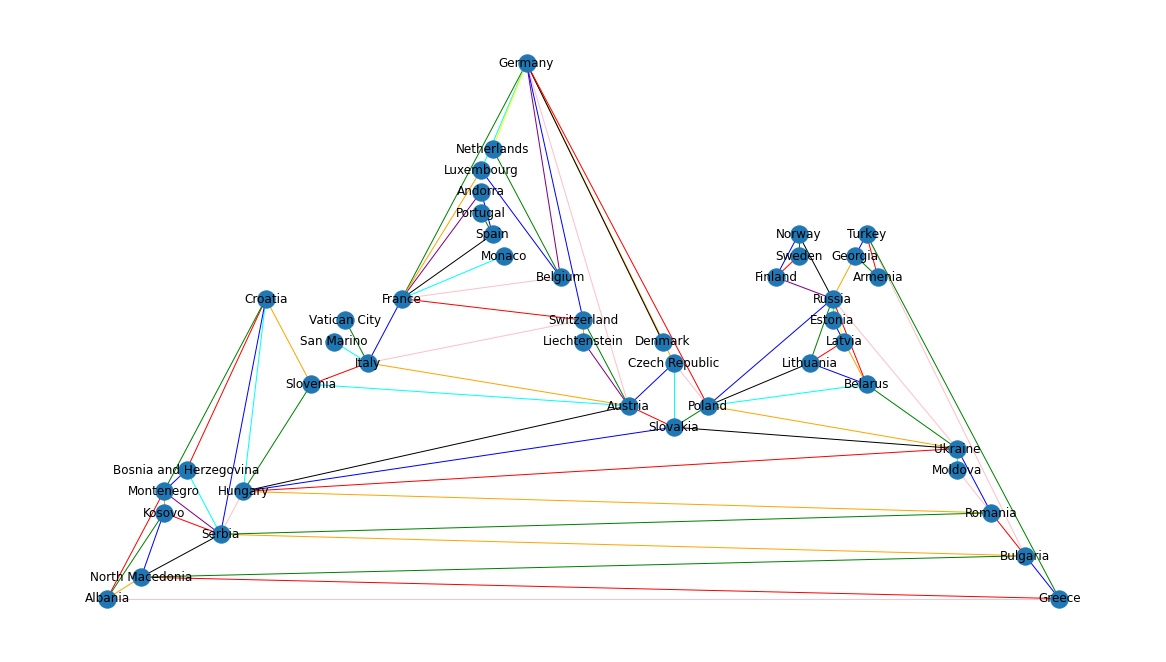

In [58]:
G_line_graph = nx.line_graph(G)
edge_colors = nx.greedy_color(G_line_graph, 'smallest_last')
colors = ['blue', 'green', 'red', 'orange', 'pink'
          , 'cyan', 'black', 'purple', 'yellow']
print('Size of edge coloring:', pd.Series(edge_colors).nunique())
nx.draw_planar(G, with_labels=True, edge_color=[colors[edge_colors[edge]] for edge in G.edges()])

#### 1e
#### Find the maximum clique Q ⊆ V of G.

Maximum clique: {'Belarus', 'Lithuania', 'Russia', 'Latvia'}


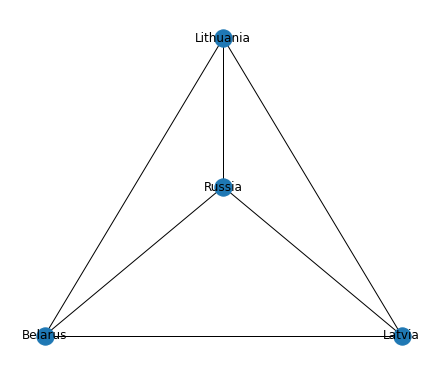

In [19]:
cliques = list(nx.find_cliques_recursive(G))
max_clique_size = 0
for element in cliques:
    max_clique_size = max(max_clique_size, len(element))

plt.figure(figsize=(6, 5))
print('Maximum clique:', clique.max_clique(G))
nx.draw_planar(G.subgraph(clique.max_clique(G)), with_labels=True)

#### 1f

#### Find the maximum stable set S ⊆ V of G.

For some reason, `maximum_independent_set(G)` returns 16 vertices, 
whereas the maximum value seems to be 19 (was found by 10^6 tries - shoutout to Vlad Hober)<br>
This is why I have applied an Image of correct maximum independent set of size 19 <br>
Independent set vertices were colored in **cyan**

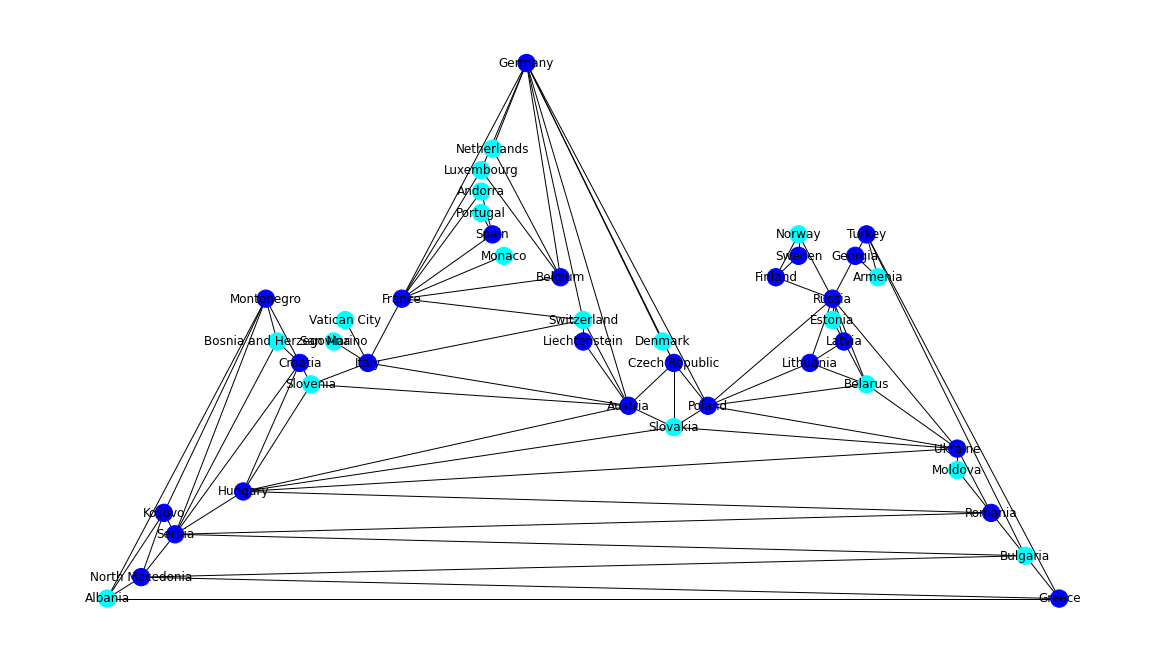

In [59]:
# maximum_independet_set = nx.algorithms.approximation.maximum_independent_set(G)

# print('Size:', len(maximum_independet_set))
# colors = list()
# colors= ['cyan' if node in  maximum_independet_set \
#          else 'blue' for node in G.nodes()]
# nx.draw_planar(G, node_color=colors, with_labels=True)


Image(filename='maximum_stable_set.png') 

#### 1g
#### Find the maximum matching M ⊆ E of G.
`nx.maximal_matching(G)` is also changing even with fixed random.seed <br>
So I have simply applied an image of correct maximal_matching <br>
Red color = edges from matching

Size: 15


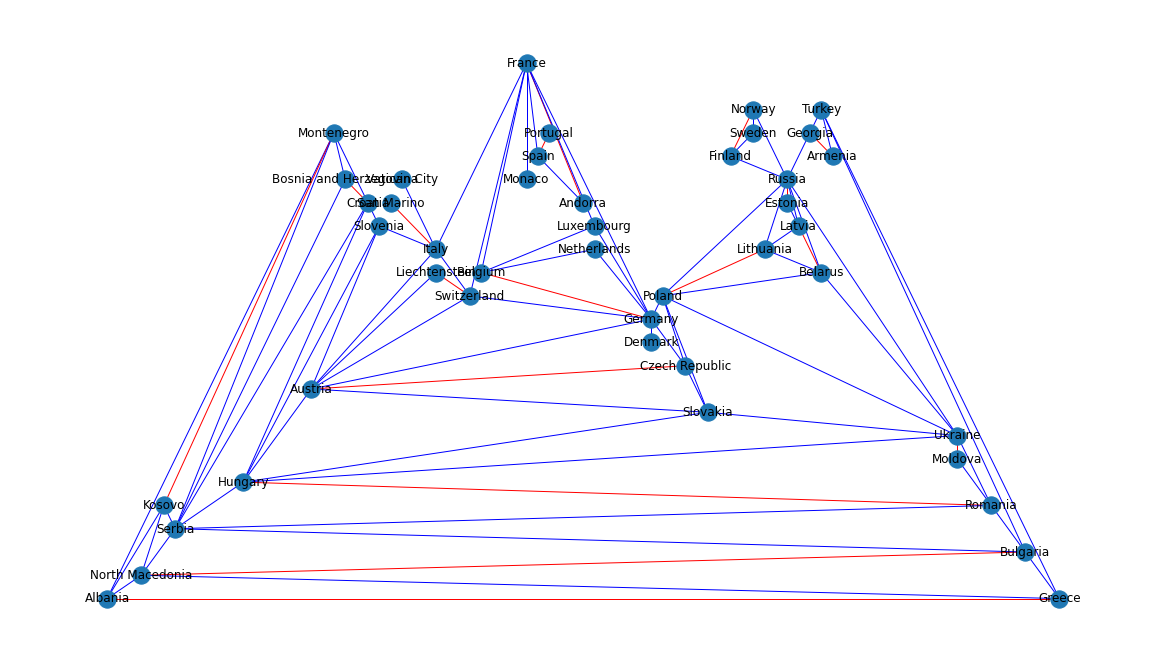

In [60]:
# print('Maximum matching:', nx.maximal_matching(G))
# print('Size:', len(nx.maximal_matching(G)))
print('Size:', 15)
Image('maximum_matching.png')

# edge_colors = ['red' if edge in nx.maximal_matching(G) else 'blue' for edge in G.edges()]
# nx.draw_planar(G, edge_color=edge_colors, with_labels=True)

#### 1h
#### Find the minimum vertex cover R ⊆ V of G.
**Green** stands for vertex cover vertices

Using `min_weighted_vertex_cover(G)` from networkx module

34
Minimum vertex cover: {'Kosovo', 'Bosnia and Herzegovina', 'Norway', 'Croatia', 'Poland', 'Andorra', 'Moldova', 'Greece', 'Germany', 'Lithuania', 'Austria', 'Portugal', 'Albania', 'Armenia', 'Ukraine', 'Belgium', 'San Marino', 'North Macedonia', 'Bulgaria', 'Spain', 'Belarus', 'Russia', 'Liechtenstein', 'Romania', 'Georgia', 'Finland', 'Latvia', 'Italy', 'Czech Republic', 'Hungary', 'Switzerland', 'France', 'Montenegro', 'Estonia'}


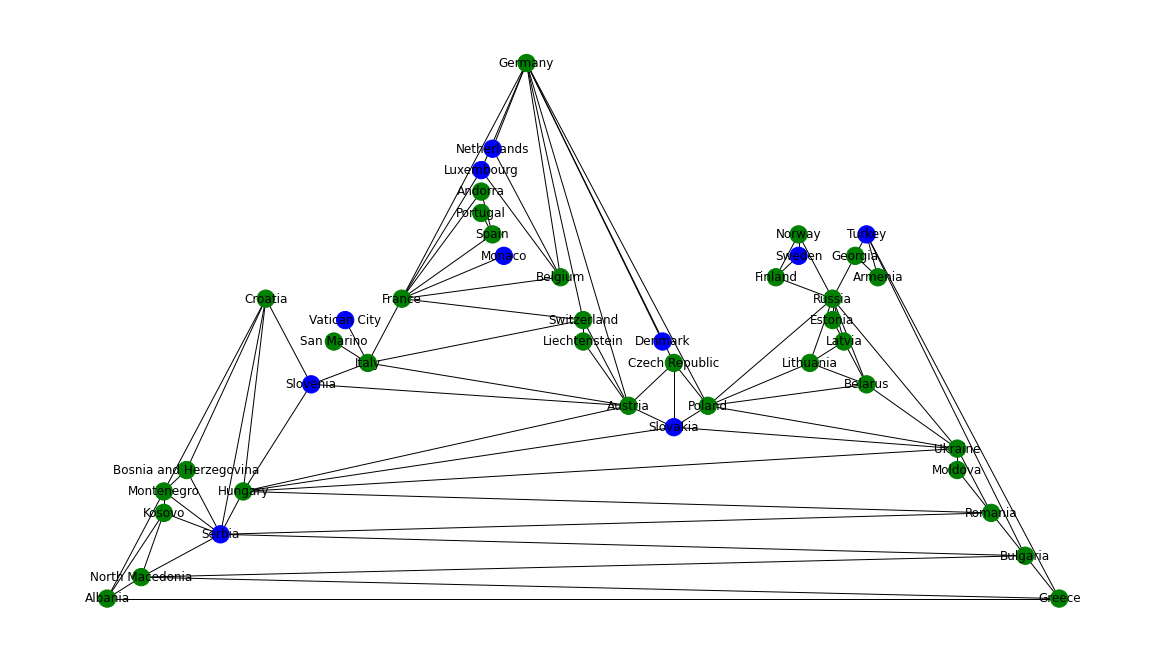

In [61]:
print(len(vertex_cover.min_weighted_vertex_cover(G)))
print('Minimum vertex cover:', vertex_cover.min_weighted_vertex_cover(G))

colors = ['green' if vertex in vertex_cover.min_weighted_vertex_cover(G) 
         else 'blue' for vertex in G.nodes()]
nx.draw_planar(G, node_color=colors, with_labels=True)

#### 1i
#### Find the minimum edge cover F ⊆ E of G.
**Red** stands for edge cover edges

Size: 28


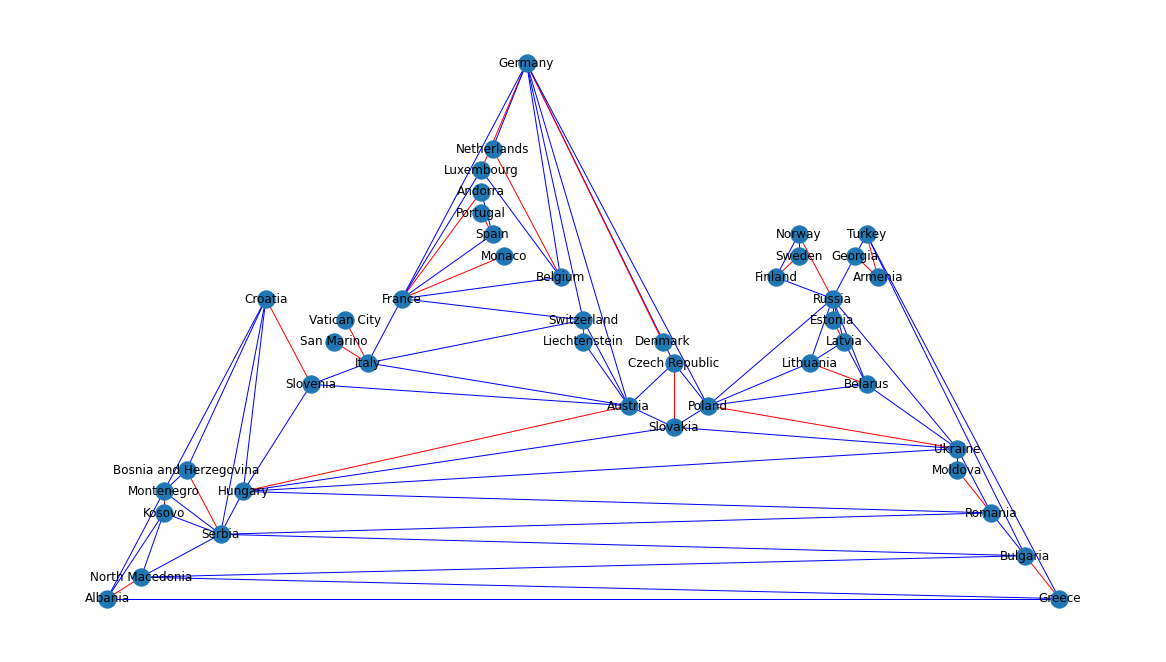

In [62]:
minimum_edge_cover = list(nx.min_edge_cover(G))
print('Size:', len(minimum_edge_cover))

"""
Correctly get edge color to display the colored graph
"""
temp = minimum_edge_cover.copy()
for edge in temp:
    minimum_edge_cover.append((edge[1], edge[0]))

edge_colors = ['red' if edge in minimum_edge_cover else 'blue' for edge in G.edges()]
nx.draw_planar(G, edge_color=edge_colors, with_labels=True)

#### 1j
#### Find the shortest closed walk W that visits every vertex of G.
Task 1j basically refers to *the traveling salesman problem*, so I used its implementation

In [75]:
vertex_path = nx.approximation.traveling_salesman_problem(G)
print('Size:', len(vertex_path))
'->'.join(vertex_path)

Size: 60


'Armenia->Turkey->Bulgaria->Romania->Moldova->Ukraine->Belarus->Lithuania->Russia->Finland->Sweden->Norway->Russia->Estonia->Latvia->Belarus->Poland->Czech Republic->Austria->Slovenia->Austria->Slovakia->Austria->Switzerland->Liechtenstein->Austria->Italy->Vatican City->Italy->San Marino->Italy->France->Spain->Portugal->Spain->Andorra->France->Monaco->France->Belgium->Netherlands->Germany->Denmark->Germany->Luxembourg->Germany->Austria->Hungary->Croatia->Bosnia and Herzegovina->Serbia->Montenegro->Albania->North Macedonia->Kosovo->Albania->Greece->Turkey->Georgia->Armenia'

#### 1k

#### Find the shortest closed walk U that visits every edge of G.
Do the same for a G's `line graph` (as there is bijection) 

I did not print the edges' sequence, as it would make the output too bulky

In [76]:
edge_path = nx.approximation.traveling_salesman_problem(nx.line_graph(G))
print('Size:', len(edge_path))

Size: 103


#### 1l
#### Find all biconnected components (blocks) and draw the block-cut tree of `G*`
Draw *block-cut tree* by hands, write down the articulation points and then connect the blocks

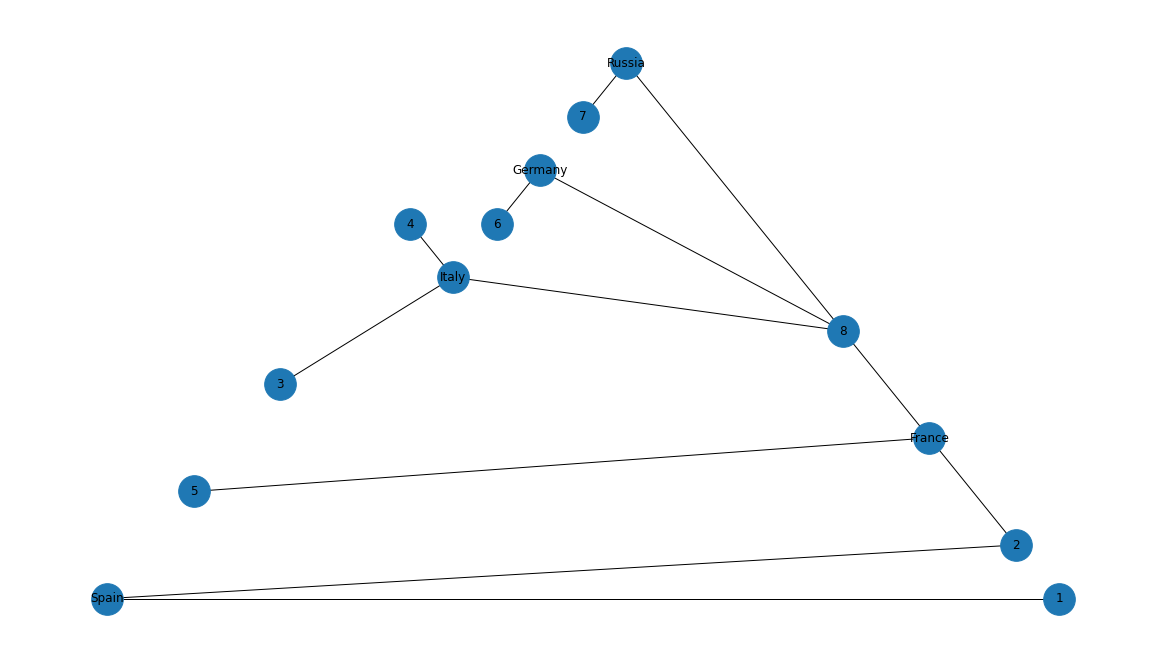

In [29]:
"""
    Add blocks (the same indexes as in bicon_components list)
"""
bicon_components = list(nx.biconnected_components(Europe))
block_cut_tree = nx.Graph()

for point in nx.articulation_points(Europe):
    for i in range(len(bicon_components)):
        if point in bicon_components[i]:
            block_cut_tree.add_edge(point, i + 1)

nx.draw_planar(block_cut_tree, with_labels=True, node_size=1000)

#### 1m
#### (m)Find all 2-edge-connected components of `G*`.
Coloring each 2-edge-connected component for `Europe`

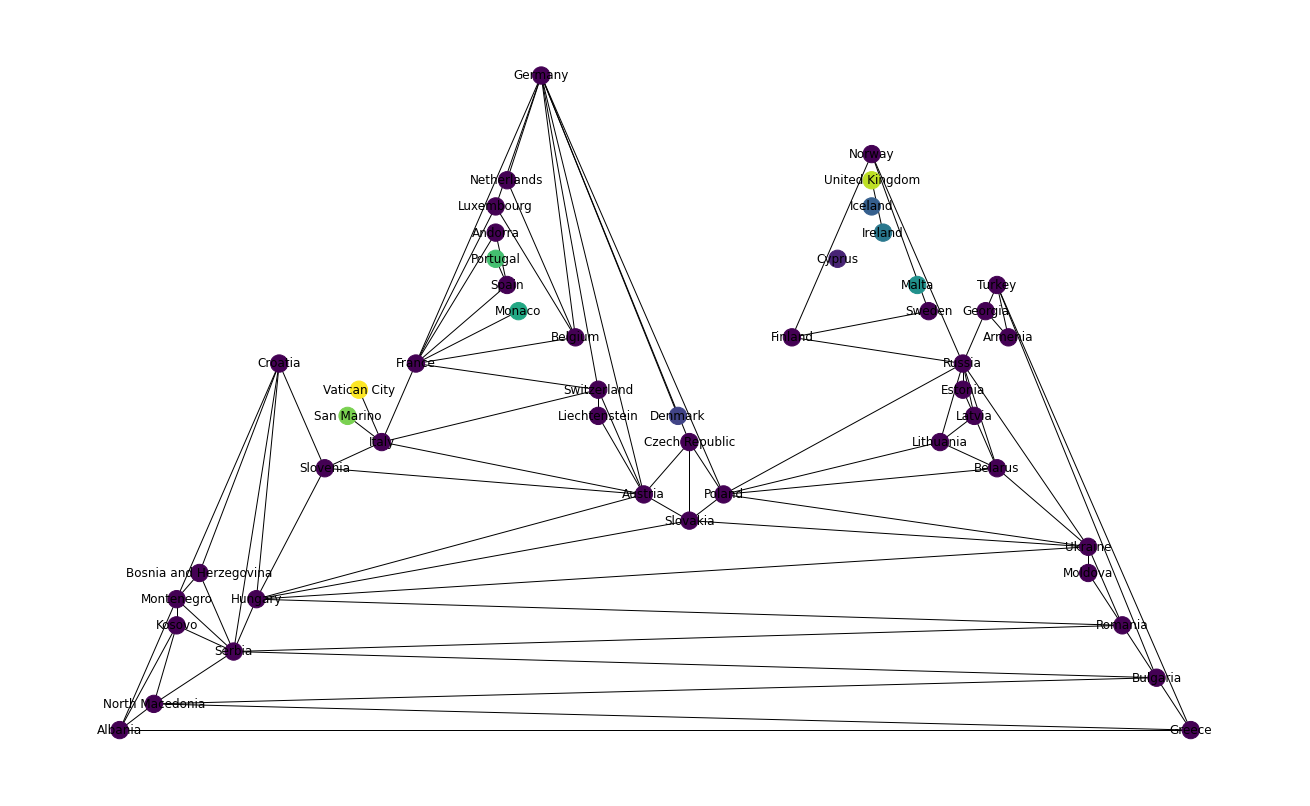

In [78]:
plt.figure(figsize=(18, 11))
node_colors = dict()
color = 0
for component in nx.k_edge_components(Europe, 2):
    for node in component:
        node_colors[node] = color
    color += 1 

"""
    Separate color for each component
"""
    
nx.draw_planar(Europe, node_color=[node_colors[node] for node in Europe.nodes()]
               , with_labels=True)


#### 1n
#### Construct an SPQR tree of the largest biconnected component of G.
Going to import the largest biconnected component of G at **sagecell.sagemath.org**,
since I haven't found another module for constructing an `SPQR tree`

In [33]:
# nx.to_dict_of_lists(largest_bicon_comp)

Inserted sage code 
>``graph_dict = {...}
graph = Graph(graph_dict)
graph = graph.to_undirected()
tree = graph.spqr_tree()
plot(tree)``

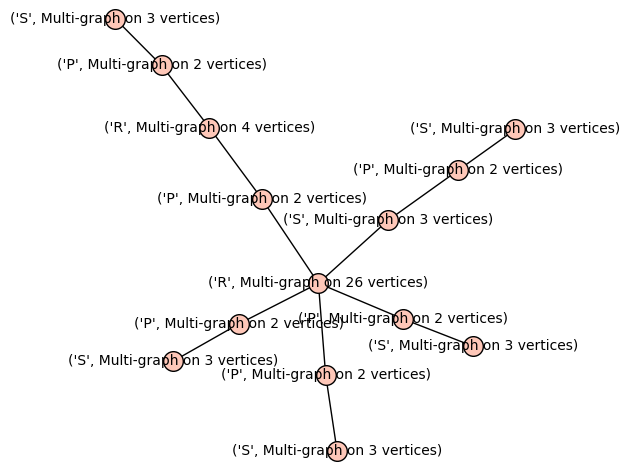

In [34]:
Image(filename='spqr_tree.png')

#### 1o
#### Add the weight functionw : E → R denoting the distance5 between capitals. Find the minimum
#### (w.r.t. the total weight of edges) spanning tree T for the largest connected component of the
#### weighted Europe graph
I have already preprocessed the capitals' coordinates data, so I did not apply it here

In [35]:
!pip install geopy

  Using cached geopy-2.2.0-py3-none-any.whl (118 kB)
  Using cached geographiclib-1.52-py3-none-any.whl (38 kB)


`geopy` used to calculate distances between capitals, according to (latitude, longitude)

In [79]:
import geopy.distance as gd

Europe_weighted = nx.Graph()
Europe_weighted.add_nodes_from(list(Europe.nodes()))

capitals_coordinates = pd.read_csv('coordinates.csv')
capitals_coordinates['coords'] = list(zip(capitals_coordinates.latitude,
                                          capitals_coordinates.longitude))

for edge in Europe.edges():
    left = edge[0]
    right = edge[1]

    coords_left = capitals_coordinates[capitals_coordinates.country == left].coords.values[0]
    coords_right = capitals_coordinates[capitals_coordinates.country == right].coords.values[0]

    distance = int(gd.geodesic(coords_left, coords_right).km)
    Europe_weighted.add_edge(left, right, weight=distance)

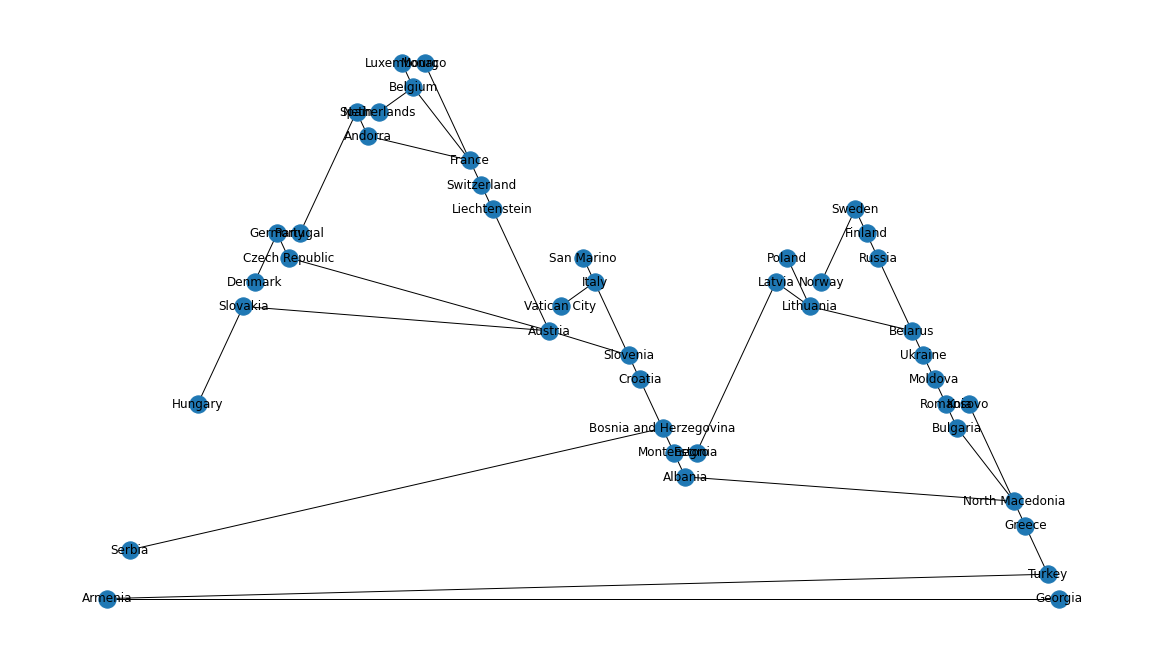

In [81]:
"""
Adding weights
"""

Gw = Europe_weighted.subgraph(max(nx.connected_components(Europe_weighted)))
T = nx.minimum_spanning_tree(Gw)
nx.draw_planar(T, with_labels=True)

#### 1p
Find centroid(T) (w.r.t. the edge weight function w).

In [82]:
"""
A workaround solution without built-in functions usage
get_weight invokes dfs for every neighbour (branch) of the vertice
Then dfs counts the branch's weight
"""
class VertexWeightFunction:
    weight = 0 
    
    def __init__(self):
        pass
    
    def dfs(self, vertice: str, graph: nx.Graph
            , visited_edges: dict, weights: dict):
        
        for neighbour in graph.neighbors(vertice):
            if not visited_edges[frozenset({vertice, neighbour})]:
                visited_edges[frozenset({vertice, neighbour})] = True
                self.weight += weights[frozenset({vertice, neighbour})]
                self.dfs(neighbour, graph, visited_edges
                    , weights)

    """
    vertice: vertice the weight of which you want to get
    graph: the graph
    visited_edges: shows whether each edge was visited or not
    weights: dict with edges' weights
    """
    def get_weight(self, vertice: str, graph: nx.Graph
                   , visited_edges: dict, weights: dict):
        max_weight = 0
        for neighbour in graph.neighbors(vertice):
            global weight
            self.weight = weights[frozenset({vertice, neighbour})]
            visited_edges[frozenset({vertice, neighbour})] = True
            self.dfs(neighbour, graph, visited_edges, weights)
            max_weight = max(max_weight, self.weight)
        return max_weight

In [83]:
vertex_weights = []
weights = {}
for edge in T.edges():
    weights[frozenset(edge)] = T[edge[0]][edge[1]]['weight']
for vertex in T.nodes():
    visited_edges = {frozenset(edge): False for edge in T.edges()}

    vertex_weights.append(VertexWeightFunction() \
                       .get_weight(vertex, T, visited_edges, weights))
min(vertex_weights)

7302

In [84]:
country_index = 0
for i in range(len(vertex_weights)):
    if vertex_weights[i] == min(vertex_weights):
        country_index = i
        break
print('Centroid for T:', list(T.nodes())[country_index])

Centroid for T: North Macedonia


#### 1q
#### Construct the Prufer code for  ̈ T .
{1...n} labels correspond to the countries' 'Happiness ranks'

In [43]:
happiness_df = pd.read_csv('happiness.csv')

happiness_df = happiness_df.drop(['Rank', 'Change in happiness (2005-2006)'], axis=1)
happiness_df = happiness_df.rename(columns={
    'Country': 'country'
})

T_countries = pd.DataFrame(list(T.nodes()))
T_countries.columns = ['country']

In [44]:
T_happiness_df = happiness_df.merge(T_countries, how='right')
# Fill the missing values with median 
T_happiness_df = T_happiness_df.fillna(T_happiness_df['Happiness'] \
                                       .median())

T_happiness_df['rank'] = T_happiness_df['Happiness'] \
                             .rank(method='first', ascending=False) - 1
T_happiness_df['rank'] = T_happiness_df['rank'].map(int)
T_happiness_df = T_happiness_df.drop(columns=['Happiness'], axis=1) \
                                        .sort_values(by='rank')
T_happiness_df

,country,rank
12,Finland,0
29,Norway,1
40,Switzerland,2
27,Netherlands,3
39,Sweden,4
3,Austria,5
23,Luxembourg,6
5,Belgium,7
13,France,8
14,Germany,9


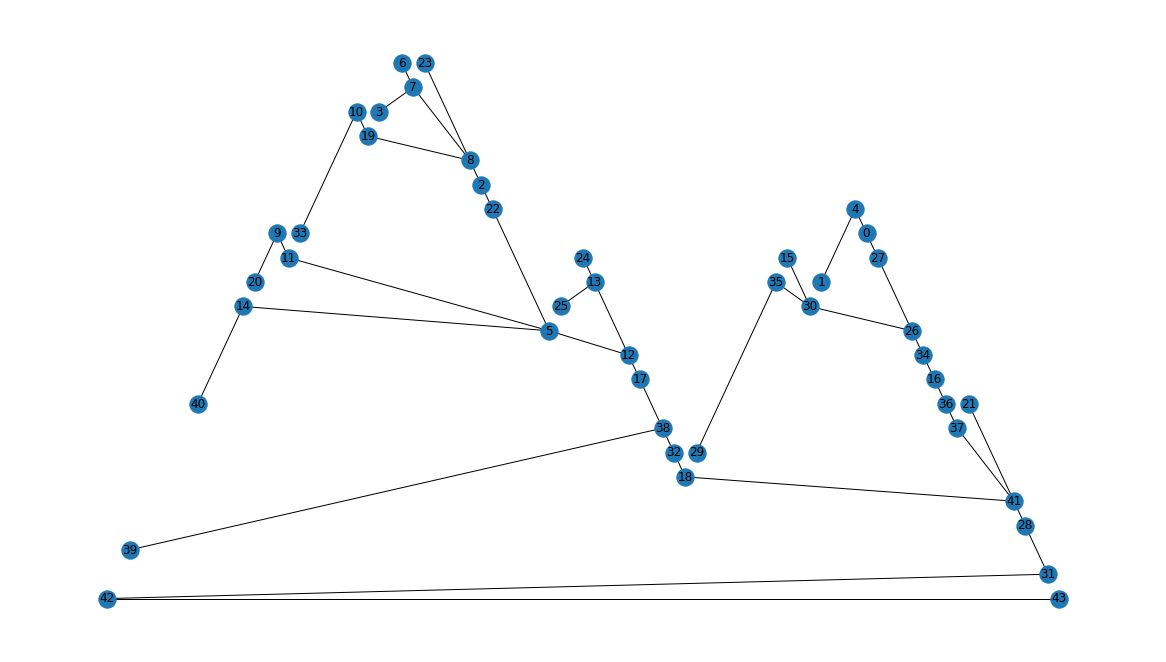

In [45]:
label_mapping = {node: T_happiness_df[T_happiness_df.country == node]['rank'].values[0] \
                 for node in T.nodes()}
T_labeled = nx.relabel_nodes(T, label_mapping)
nx.draw_planar(T_labeled, with_labels=True)

##### Prufer sequence:

In [46]:
"-".join([str(x) for x in nx.to_prufer_sequence(T_labeled)])

'4-7-0-27-7-8-30-9-11-5-41-8-13-13-12-26-35-10-19-8-2-22-5-30-26-34-16-36-37-41-38-14-5-12-17-38-32-18-41-28-31-42'